In [1]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

from collections import OrderedDict
from tqdm import tqdm

sns.set_style("white")

In [2]:
# Multi-layer Perceptron
class NN(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
        depth,
        act=torch.nn.Tanh,
    ):
        super(NN, self).__init__()
        
        layers = [('input', torch.nn.Linear(input_size, hidden_size))]
        layers.append(('input_activation', act()))
        for i in range(depth): 
            layers.append(('hidden_%d' % i, torch.nn.Linear(hidden_size, hidden_size)))
            layers.append(('activation_%d' % i, act()))
        layers.append(('output', torch.nn.Linear(hidden_size, output_size)))

        layerDict = OrderedDict(layers)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

In [3]:
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.model = NN(
            input_size=2,
            hidden_size=20,
            output_size=1,
            depth=4,
            act=torch.nn.Tanh
        ).to(device)
        
        self.h = 0.01
        self.k = 0.01
        x = torch.arange(-1, 1, self.h)
        t = torch.arange(0, 1, self.k)
        #print("x: ", x.shape, "t: ", t.shape)

        # exact solution
        self.X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T
        #print("X",self.X.shape)
        
        # training data
        bc1 = torch.stack(torch.meshgrid(x[0], t)).reshape(2, -1).T
        bc2 = torch.stack(torch.meshgrid(x[-1], t)).reshape(2, -1).T
        ic = torch.stack(torch.meshgrid(x, t[0])).reshape(2, -1).T
        self.X_train = torch.cat([bc1, bc2, ic])
        #print("X_train",self.X_train.shape)
        
        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))
        y_ic = torch.sin(math.pi * ic[:, 0])
        #print("y_bc1: ", y_bc1.shape, "y_bc2: ", y_bc2.shape, "y_ic: ", y_ic.shape)
        self.y_train = torch.cat([y_bc1, y_bc2, y_ic])
        self.y_train = self.y_train.unsqueeze(1)
        
        self.X = self.X.to(device)
        self.X_train = self.X_train.to(device)
        self.y_train = self.y_train.to(device)
        self.X.requires_grad = True
        
        self.criterion = torch.nn.MSELoss()
        self.iter = 1
        
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps
        )
        
        self.adam = torch.optim.Adam(self.model.parameters())

    def loss_func(self):
        self.optimizer.zero_grad()
        
        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred, self.y_train)

        y = self.model(self.X)
        
        x = self.X[:,0]
        t = self.X[:,1]
        #print("Inside x: ", x.shape, "t: ", t.shape)
        dy_dX = torch.autograd.grad(inputs=self.X, outputs=y, grad_outputs=torch.ones_like(y), retain_graph=True, create_graph=True)[0]
        #print("dy_dX: ", dy_dX.shape)
        dy_dx = dy_dX[:, 0]
        #print("dy_dx: ", dy_dx.shape)
        dy_dt = dy_dX[:, 1]
        #print("dy_dt; ", dy_dt.shape)
        dy_dxx = torch.autograd.grad(inputs=self.X, outputs=dy_dX, grad_outputs=torch.ones_like(dy_dX), retain_graph=True, create_graph=True)[0][:, 0]
        #print("dy_dxx: ", dy_dxx.shape)
        loss_pde = self.criterion(dy_dt - dy_dxx, (torch.exp(-t))*(torch.sin(math.pi * x) - (math.pi)*(math.pi)*torch.sin(math.pi * x)))

        loss = loss_pde + loss_data
        loss.backward()
        if self.iter % 100 == 0: 
            print(self.iter, loss.item())
        self.iter = self.iter + 1
        return loss
    
    def train(self):
        for i in range(10000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

In [4]:
net = Net()
net.train()

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


100 5.66450309753418
200 0.7364075183868408
300 0.4393140375614166
400 0.33072540163993835
500 0.2511405646800995
600 0.1701516956090927
700 0.11730222404003143
800 0.08100207149982452
900 0.05592451989650726
1000 0.04289111867547035
1100 0.03459528461098671
1200 0.02836180105805397
1300 0.024669211357831955
1400 0.01940520480275154
1500 0.015996765345335007
1600 0.013257630169391632
1700 0.011323069222271442
1800 0.009190124459564686
1900 0.007851297967135906
2000 0.006913837511092424
2100 0.0062369490042328835
2200 0.006530490703880787
2300 0.005447026342153549
2400 0.009034582413733006
2500 0.004806550685316324
2600 0.004619504325091839
2700 0.0044718277640640736
2800 0.004361783154308796
2900 0.004269410856068134
3000 0.004108293913304806
3100 0.004056347068399191
3200 0.003970942460000515
3300 0.0038451338186860085
3400 0.003768196329474449
3500 0.00447520287707448
3600 0.0036324812099337578
3700 0.005330342799425125
3800 0.0035127606242895126
3900 0.0034544027876108885
4000 0.003

In [5]:
h = 0.01
k = 0.01
x = torch.arange(-1, 1, h)
t = torch.arange(0, 1, k)

# exact solution
X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T
X = X.to(net.X.device)

In [6]:
model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X).reshape(len(x), len(t)).cpu().numpy()

<AxesSubplot:>

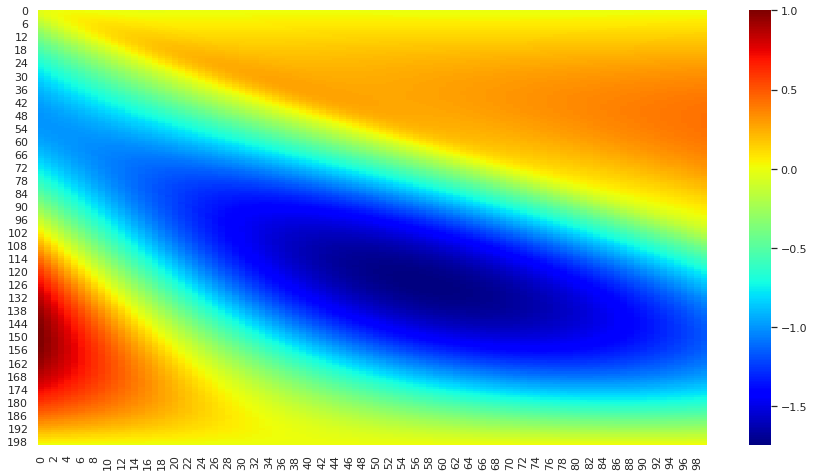

In [7]:
sns.set(rc={'figure.figsize': (15, 8)})
sns.heatmap(y_pred, cmap='jet')

In [8]:
mat = {'v': y_pred}
scipy.io.savemat('diffusion_pinn.mat', mat)